## Import packages necessary for modeling

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read in crash dataset from 2019 - 2024

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/model_df.csv')
del df['YEAR']

## Dataset Summary



*   199,731 rows
*   9 features
*   9 categorical variables


In [ ]:
df.head(5)

,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,zip,POSTED_SPEED_LIMIT,severe
0,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,STATIONARY/FIXED,DIVIDED ROAD,DRY,60608,(26-35) MODERATE,0
1,TRAFFIC SIGNAL,FUNCTIONING IMPROPERLY,CLEAR,DAYLIGHT,INTERSECTION,INTERSECTION,DRY,60621,(26-35) MODERATE,0
2,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR IMPACT,UNDIVIDED ROAD,DRY,60625,(26-35) MODERATE,0
3,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,INTERSECTION,INTERSECTION,DRY,60614,(26-35) MODERATE,0
4,NO CONTROLS,NOT FUNCTIONING,CLEAR,DAYLIGHT,STATIONARY/FIXED,UNDIVIDED ROAD,DRY,60639,(16-25) LOW,0


In [ ]:
df.shape

(199731, 10)

In [ ]:
counts = df['severe'].value_counts()

severe = counts.get(1, 0)
non_severe = counts.get(0, 0)

print(f'Total Non-Severe Cases: {non_severe}')
print(f'Total Severe Cases: {severe}')

Total Non-Severe Cases: 194675
Total Severe Cases: 5056


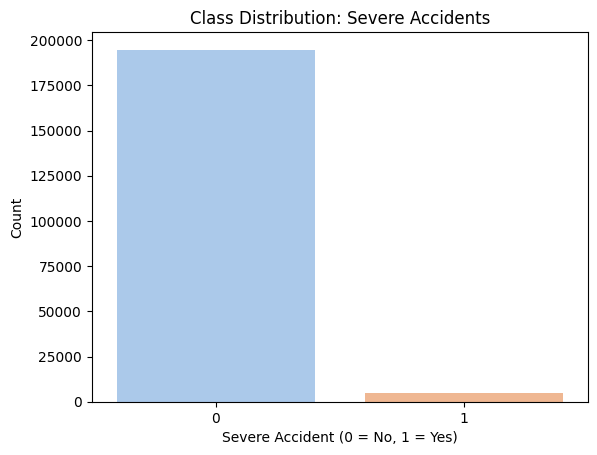

In [ ]:
sns.countplot(x='severe', hue = 'severe', data=df, palette = 'pastel', legend = False)
plt.title('Class Distribution: Severe Accidents')
plt.xlabel('Severe Accident (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [ ]:
colnames = df.columns
unique_data = {
    col: ', '.join(map(str, df[col].dropna().unique())) for col in colnames
}

unique_df = pd.DataFrame.from_dict(unique_data, orient='index', columns=['Unique Values'])
unique_df

,Unique Values
TRAFFIC_CONTROL_DEVICE,"TRAFFIC SIGNAL, STOP SIGN/FLASHER, NO CONTROLS..."
DEVICE_CONDITION,"FUNCTIONING PROPERLY, FUNCTIONING IMPROPERLY, ..."
WEATHER_CONDITION,"CLEAR, CLOUDY/OVERCAST, RAIN, SNOW"
LIGHTING_CONDITION,"DAYLIGHT, DARKNESS, LIGHTED ROAD, LOW LIGHT, D..."
FIRST_CRASH_TYPE,"STATIONARY/FIXED, INTERSECTION, REAR IMPACT, P..."
TRAFFICWAY_TYPE,"DIVIDED ROAD, INTERSECTION, UNDIVIDED ROAD, ST..."
ROADWAY_SURFACE_COND,"DRY, WET, SNOW OR SLUSH, ICE"
zip,"60608, 60621, 60625, 60614, 60639, 60646, 6064..."
POSTED_SPEED_LIMIT,"(26-35) MODERATE, (16-25) LOW, (36-45) HIGH, (..."
severe,"0, 1"


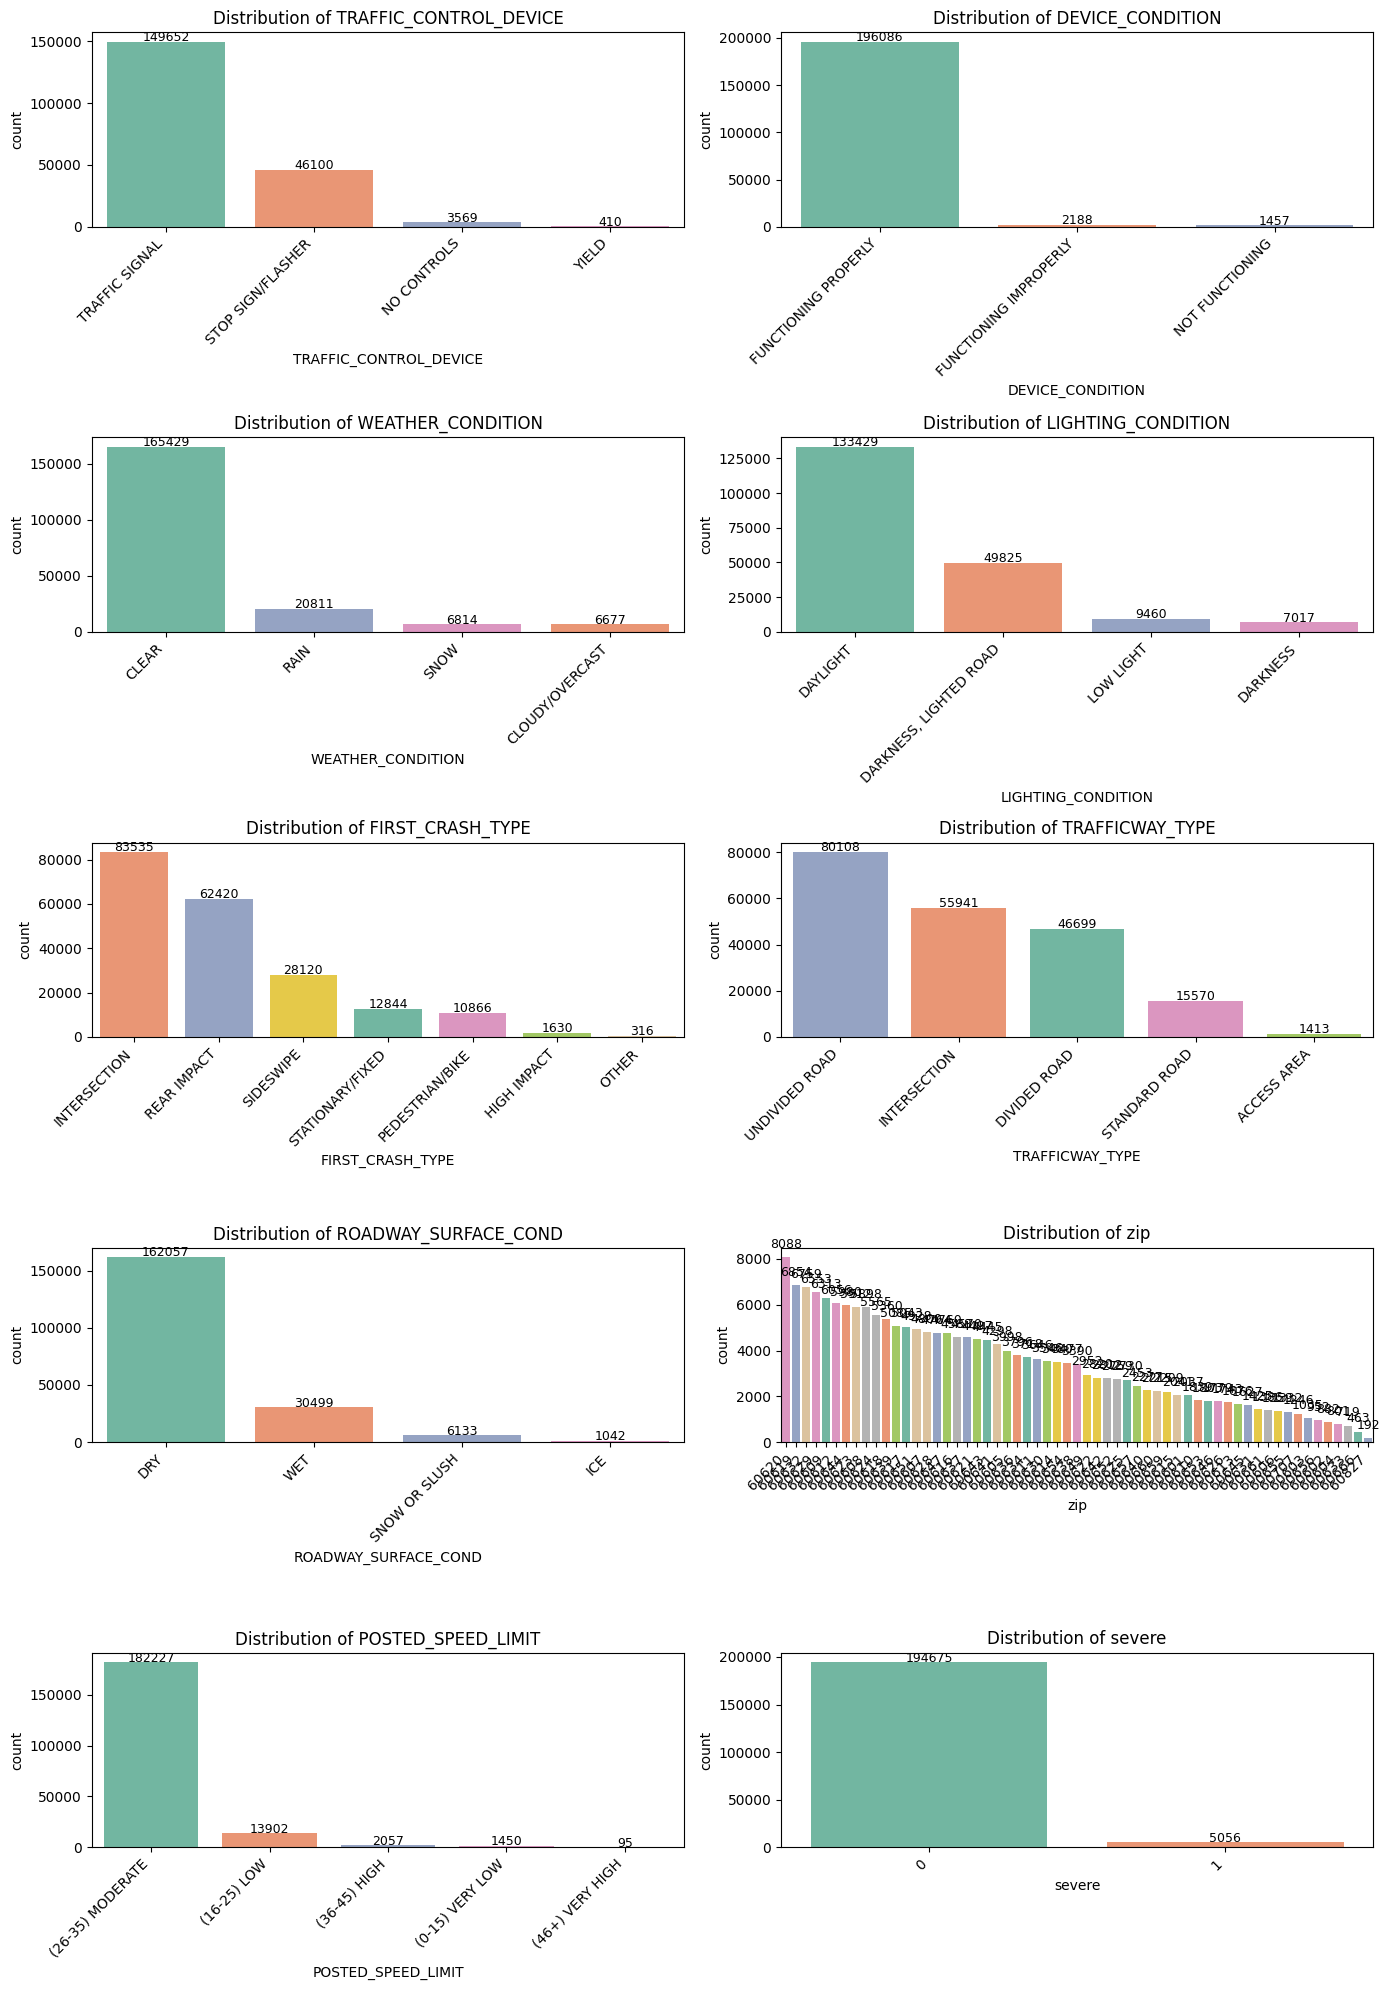

In [ ]:
num_cols = len(colnames)
n_cols = 2
n_rows = (num_cols + n_cols - 1) // n_cols

plt.figure(figsize=(14, n_rows * 4))

for i, col in enumerate(colnames):
    plt.subplot(n_rows, n_cols, i + 1)

    order = df[col].value_counts().index
    palette = sns.color_palette("Set2", n_colors=len(order))

    ax = sns.countplot(data=df, x=col, hue=col, order=order, palette=palette, legend=False)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., height + 400,
                    f'{int(height)}', ha="center", fontsize=9)

    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()


## USE LABEL ENCODER TO TRANSFORM CATEGORICAL VARIABLES TO NUMERICAL FOR MACHINE LEARNING

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
mappings = {}

for col in df.columns:
    if col != 'severe':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))


In [ ]:
mappings

{'TRAFFIC_CONTROL_DEVICE': {'NO CONTROLS': np.int64(0),
  'STOP SIGN/FLASHER': np.int64(1),
  'TRAFFIC SIGNAL': np.int64(2),
  'YIELD': np.int64(3)},
 'DEVICE_CONDITION': {'FUNCTIONING IMPROPERLY': np.int64(0),
  'FUNCTIONING PROPERLY': np.int64(1),
  'NOT FUNCTIONING': np.int64(2)},
 'WEATHER_CONDITION': {'CLEAR': np.int64(0),
  'CLOUDY/OVERCAST': np.int64(1),
  'RAIN': np.int64(2),
  'SNOW': np.int64(3)},
 'LIGHTING_CONDITION': {'DARKNESS': np.int64(0),
  'DARKNESS, LIGHTED ROAD': np.int64(1),
  'DAYLIGHT': np.int64(2),
  'LOW LIGHT': np.int64(3)},
 'FIRST_CRASH_TYPE': {'HIGH IMPACT': np.int64(0),
  'INTERSECTION': np.int64(1),
  'OTHER': np.int64(2),
  'PEDESTRIAN/BIKE': np.int64(3),
  'REAR IMPACT': np.int64(4),
  'SIDESWIPE': np.int64(5),
  'STATIONARY/FIXED': np.int64(6)},
 'TRAFFICWAY_TYPE': {'ACCESS AREA': np.int64(0),
  'DIVIDED ROAD': np.int64(1),
  'INTERSECTION': np.int64(2),
  'STANDARD ROAD': np.int64(3),
  'UNDIVIDED ROAD': np.int64(4)},
 'ROADWAY_SURFACE_COND': {'DRY': 

In [ ]:
df.head(5)

,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,zip,POSTED_SPEED_LIMIT,severe
0,2,1,0,2,6,1,0,7,2,0
1,2,0,0,2,1,2,0,20,2,0
2,2,1,0,2,4,4,0,24,2,0
3,1,1,0,2,1,2,0,13,2,0
4,0,2,0,2,6,4,0,36,1,0


## APPLY SMOTE TO ADDRESS CLASS IMBALANCE

In [ ]:
X = df.drop(columns=['severe'])
y = df['severe']

print('Before SMOTE:', Counter(y))

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print('After SMOTE:', Counter(y_resampled))

Before SMOTE: Counter({0: 194675, 1: 5056})
After SMOTE: Counter({0: 194675, 1: 194675})


In [ ]:
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['severe'] = y_resampled

In [ ]:
df_balanced.head(5)

,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,zip,POSTED_SPEED_LIMIT,severe
0,2,1,0,2,6,1,0,7,2,0
1,2,0,0,2,1,2,0,20,2,0
2,2,1,0,2,4,4,0,24,2,0
3,1,1,0,2,1,2,0,13,2,0
4,0,2,0,2,6,4,0,36,1,0


In [ ]:
df_balanced['severe'].value_counts()

,count
severe,
0,194675
1,194675


In [ ]:
df_balanced.shape

(389350, 10)

## Baseline Model: Logistic Regression (No SMOTE)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Fit logistic regression baseline model using data without SMOTE
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify = y)
lr_baseline = LogisticRegression(random_state=seed)
lr_baseline.fit(X_train, y_train)

# Generate prediction values
y_pred = lr_baseline.predict(X_test)
y_prob = lr_baseline.predict_proba(X_test)[:, 1]

# Evaluate classification model on test set and generate model metrics for baseline
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0      0.975     1.000     0.987     38936
           1      0.000     0.000     0.000      1011

    accuracy                          0.975     39947
   macro avg      0.487     0.500     0.494     39947
weighted avg      0.950     0.975     0.962     39947

Confusion Matrix:
 [[38936     0]
 [ 1011     0]]
ROC-AUC Score: 0.6086841487016559


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Baseline Model: Logistic Regression (with SMOTE)

In [ ]:
# Create random forest classifier model
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed, stratify = y_resampled)
lr_baseline = LogisticRegression(random_state=seed)
lr_baseline.fit(X_train, y_train)

# Generate prediction values
y_pred = lr_baseline.predict(X_test)
y_prob = lr_baseline.predict_proba(X_test)[:, 1]

# Evaluate classification model on test set and generate model metrics for baseline with SMOTE
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0      0.601     0.614     0.607     38935
           1      0.605     0.592     0.598     38935

    accuracy                          0.603     77870
   macro avg      0.603     0.603     0.603     77870
weighted avg      0.603     0.603     0.603     77870

Confusion Matrix:
 [[23895 15040]
 [15889 23046]]
ROC-AUC Score: 0.6589876625418889


## Model 1: Random Forest Classifier (with SMOTE)

Classification Report:
               precision    recall  f1-score   support

           0      0.867     0.766     0.813     38935
           1      0.790     0.883     0.834     38935

    accuracy                          0.824     77870
   macro avg      0.829     0.824     0.824     77870
weighted avg      0.829     0.824     0.824     77870

Confusion Matrix:
 [[29816  9119]
 [ 4561 34374]]
ROC-AUC Score: 0.9102398113612087


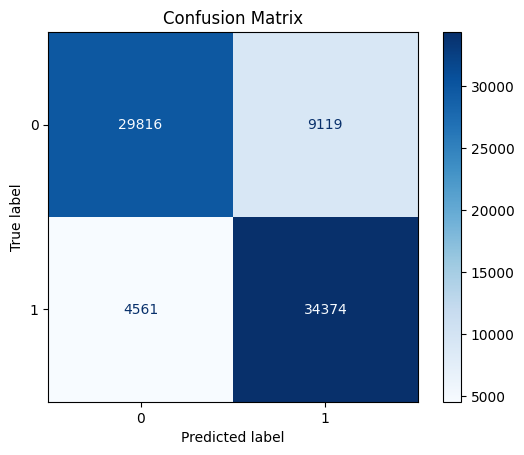

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

# Create random forest classifier model
seed = 42
rf_classifier = RandomForestClassifier(n_estimators=27, random_state=seed)
rf_classifier.fit(X_train, y_train)

# Generate prediction values
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

ConfusionMatrixDisplay.from_estimator(rf_classifier, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


## BEST MODEL, SAVE TO USE IN R SHINY ##
# import pickle

# with open('rf_classifier.pkl', 'wb') as f:
#     pickle.dump(rf_classifier, f)

## Model 2: Naive Bayes Classifier (with SMOTE)

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create Naive Bayes classifier model
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = nb_classifier.predict(X_test)
y_prob = nb_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0      0.638     0.478     0.546     38935
           1      0.583     0.728     0.647     38935

    accuracy                          0.603     77870
   macro avg      0.610     0.603     0.597     77870
weighted avg      0.610     0.603     0.597     77870

Confusion Matrix:
 [[18610 20325]
 [10573 28362]]
ROC-AUC Score: 0.6487195303608901


## Model 3: XGBoost Classifier (with SMOTE)

In [ ]:
from xgboost import XGBClassifier

# Create XGBoost classifier model
seed = 42
xgb_classifier = XGBClassifier(random_state=seed)
xgb_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0      0.787     0.743     0.765     38935
           1      0.757     0.799     0.777     38935

    accuracy                          0.771     77870
   macro avg      0.772     0.771     0.771     77870
weighted avg      0.772     0.771     0.771     77870

Confusion Matrix:
 [[28940  9995]
 [ 7828 31107]]
ROC-AUC Score: 0.856237461424159


## Model 4: Decision Tree (with SMOTE)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree classifier model
seed = 42
dt_classifier = DecisionTreeClassifier(random_state=seed)
dt_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = dt_classifier.predict(X_test)
y_prob = dt_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0      0.864     0.764     0.811     38935
           1      0.789     0.880     0.832     38935

    accuracy                          0.822     77870
   macro avg      0.827     0.822     0.822     77870
weighted avg      0.827     0.822     0.822     77870

Confusion Matrix:
 [[29758  9177]
 [ 4671 34264]]
ROC-AUC Score: 0.9054764605634523


## Model 5: Multilayer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create MLP classifier model
seed = 42
mlp_classifier = MLPClassifier(random_state=seed)
mlp_classifier.fit(X_train, y_train)

# Generate predictions
y_pred = mlp_classifier.predict(X_test)
y_prob = mlp_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0      0.749     0.713     0.730     38935
           1      0.726     0.761     0.743     38935

    accuracy                          0.737     77870
   macro avg      0.737     0.737     0.737     77870
weighted avg      0.737     0.737     0.737     77870

Confusion Matrix:
 [[27764 11171]
 [ 9319 29616]]
ROC-AUC Score: 0.8218714604850352


## Model 6: Stacked Ensemble Model (with SMOTE)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Selected base models to use for stacking classifier
base_models = [
    ('rf', RandomForestClassifier(random_state=seed)),
    ('nb', GaussianNB()),
    ('xgb', XGBClassifier(random_state=seed)),
    ('dt', DecisionTreeClassifier(random_state=seed)),
    ('logistic', LogisticRegression(random_state=seed))
]

# meta-learner layer using logistic regression trained on base models predictions
stack_model = StackingClassifier(estimators=base_models,
                                 final_estimator=LogisticRegression(max_iter = 500,
                                                                    random_state=seed),
                                 cv = 5,
                                 n_jobs = -1)

# Fit model on trained balanced dataset
stack_model.fit(X_train, y_train)

# Generate predictions of stacked classifier model with test dataset
y_pred = stack_model.predict(X_test)
y_prob = stack_model.predict_proba(X_test)[:, 1]

# Evaluate stacked classifier model with metrics
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0      0.852     0.784     0.817     38935
           1      0.800     0.864     0.831     38935

    accuracy                          0.824     77870
   macro avg      0.826     0.824     0.824     77870
weighted avg      0.826     0.824     0.824     77870

Confusion Matrix:
 [[30544  8391]
 [ 5290 33645]]
ROC-AUC Score: 0.9103614561509091


## Best Baseline Model: Random Forest

After comparing multiple baseline models with each other on various performance metrics, Random Forest outperformed other models and is the suitable choice for feature importance later

## Model 7: PCA + Random Forest (with SMOTE data)

After testingg several baseline models, it is time to try to further optimize and experiment with RandomForest. We combine PCA with RandomForest Classifier to see if PCA can help reduce feature space while preserving most information.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce the number of features
seed = 42
pca = PCA(n_components=0.95, random_state = seed)
X_train_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Original number of features: {X_scaled.shape[1]}')
print(f'Number of features after PCA: {X_train_pca.shape[1]}')

# Fit Random Forest model with PCA-reduced data
rf_classifier = RandomForestClassifier(n_estimators = 27, random_state=seed)
rf_classifier.fit(X_train_pca, y_train)

# Generate predictions
y_pred = rf_classifier.predict(X_test_pca)
y_prob = rf_classifier.predict_proba(X_test_pca)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Original number of features: 9
Number of features after PCA: 8
Classification Report:
               precision    recall  f1-score   support

           0      0.867     0.767     0.814     38935
           1      0.791     0.883     0.834     38935

    accuracy                          0.825     77870
   macro avg      0.829     0.825     0.824     77870
weighted avg      0.829     0.825     0.824     77870

Confusion Matrix:
 [[29871  9064]
 [ 4570 34365]]
ROC-AUC Score: 0.9106493403432461


# Overfitting Analysis of Random Forest Hyperparameters


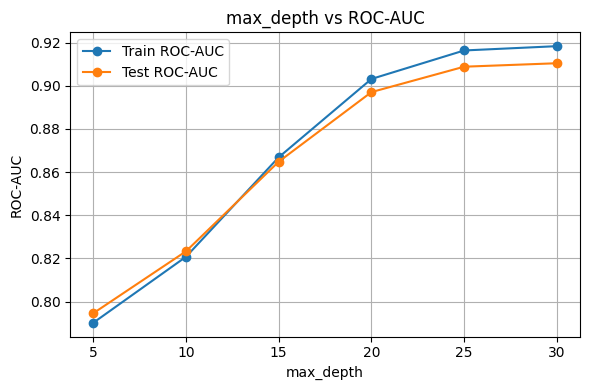

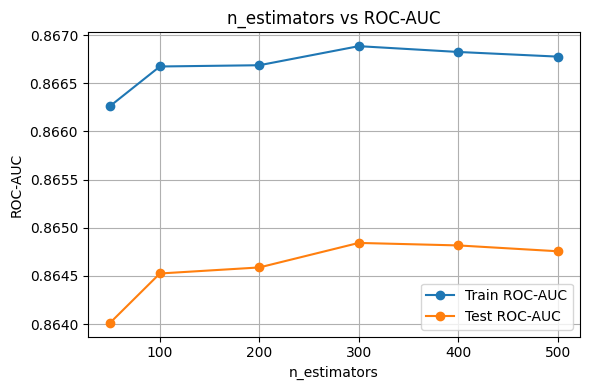

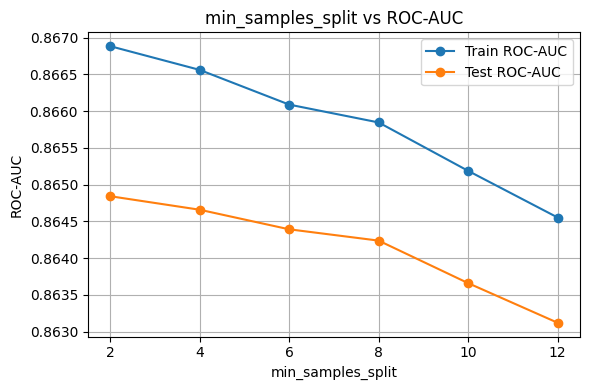

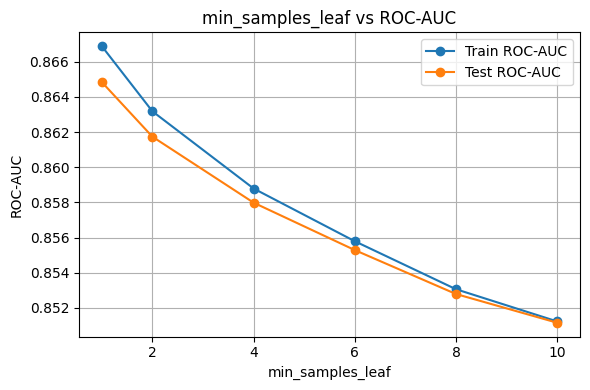

In [ ]:
# Function to automate ROC-AUC curve based on specified parameters and parameter name
def plot_param_curve(param_name, param_values, fixed_params):
    train_scores, test_scores = [], []

    for val in param_values:
        params = {param_name: val, **fixed_params}
        model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        train_prob = model.predict_proba(X_train)[:, 1]
        test_prob = model.predict_proba(X_test)[:, 1]

        train_auc = roc_auc_score(y_train, train_prob)
        test_auc = roc_auc_score(y_test, test_prob)

        train_scores.append(train_auc)
        test_scores.append(test_auc)

    plt.figure(figsize=(6, 4))
    plt.plot(param_values, train_scores, marker='o', label='Train ROC-AUC')
    plt.plot(param_values, test_scores, marker='o', label='Test ROC-AUC')
    plt.xlabel(param_name)
    plt.ylabel('ROC-AUC')
    plt.title(f'{param_name} vs ROC-AUC')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# max_depth parameter
plot_param_curve('max_depth', [5, 10, 15, 20, 25, 30], {
    'n_estimators': 300,
    'min_samples_split': 2,
    'min_samples_leaf': 1
})

# n_estimators parameter
plot_param_curve('n_estimators', [50, 100, 200, 300, 400, 500], {
    'max_depth': 15,
    'min_samples_split': 2,
    'min_samples_leaf': 1
})

# min_samples_split parameter
plot_param_curve('min_samples_split', [2, 4, 6, 8, 10, 12], {
    'max_depth': 15,
    'n_estimators': 300,
    'min_samples_leaf': 1
})

# min_samples_leaf parameter
plot_param_curve('min_samples_leaf', [1, 2, 4, 6, 8, 10], {
    'max_depth': 15,
    'n_estimators': 300,
    'min_samples_split': 2
})

## Fine tune baseline Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy.stats import randint
from sklearn.model_selection import ParameterSampler
from tqdm.notebook import tqdm

# Define parameter grid to random search over
params = {
    'n_estimators': randint(200, 400),
    'max_depth': randint(15, 50),
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Set up parameter list for 15 iterations
n_iter = 10
param_list = list(ParameterSampler(params, n_iter=n_iter, random_state=42))

# Set up blank variables for best models
best_score = 0
best_model = None
best_params = None

# Set up initial random forest model
for params in tqdm(param_list, desc="Random Search Progress"):
    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3).mean()

    if score > best_score:
        best_score = score
        best_model = model
        best_params = params

# Fit best fine-tuned model on all SMOTE training data
best_model.fit(X_train, y_train)

# Predict and evaluate on original testing dataset
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Best Hyperparameters Found:", best_params)
print("Cross-Validated ROC-AUC Score (CV mean):", round(best_score, 4))
print("\nTest Set Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score (Test Set):", round(roc_auc_score(y_test, y_prob), 4))

Best Hyperparameters Found: {'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 302}
Cross-Validated ROC-AUC Score (CV mean): 0.9048

Test Set Classification Report:
               precision    recall  f1-score   support

           0      0.867     0.768     0.815     38935
           1      0.792     0.882     0.835     38935

    accuracy                          0.825     77870
   macro avg      0.829     0.825     0.825     77870
weighted avg      0.829     0.825     0.825     77870

Confusion Matrix:
 [[29903  9032]
 [ 4585 34350]]
ROC-AUC Score (Test Set): 0.911


## Feature Importance of Model

<ipython-input-76-753b88bb2f90>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='importance', y='feature', data=feat_df, palette='viridis')


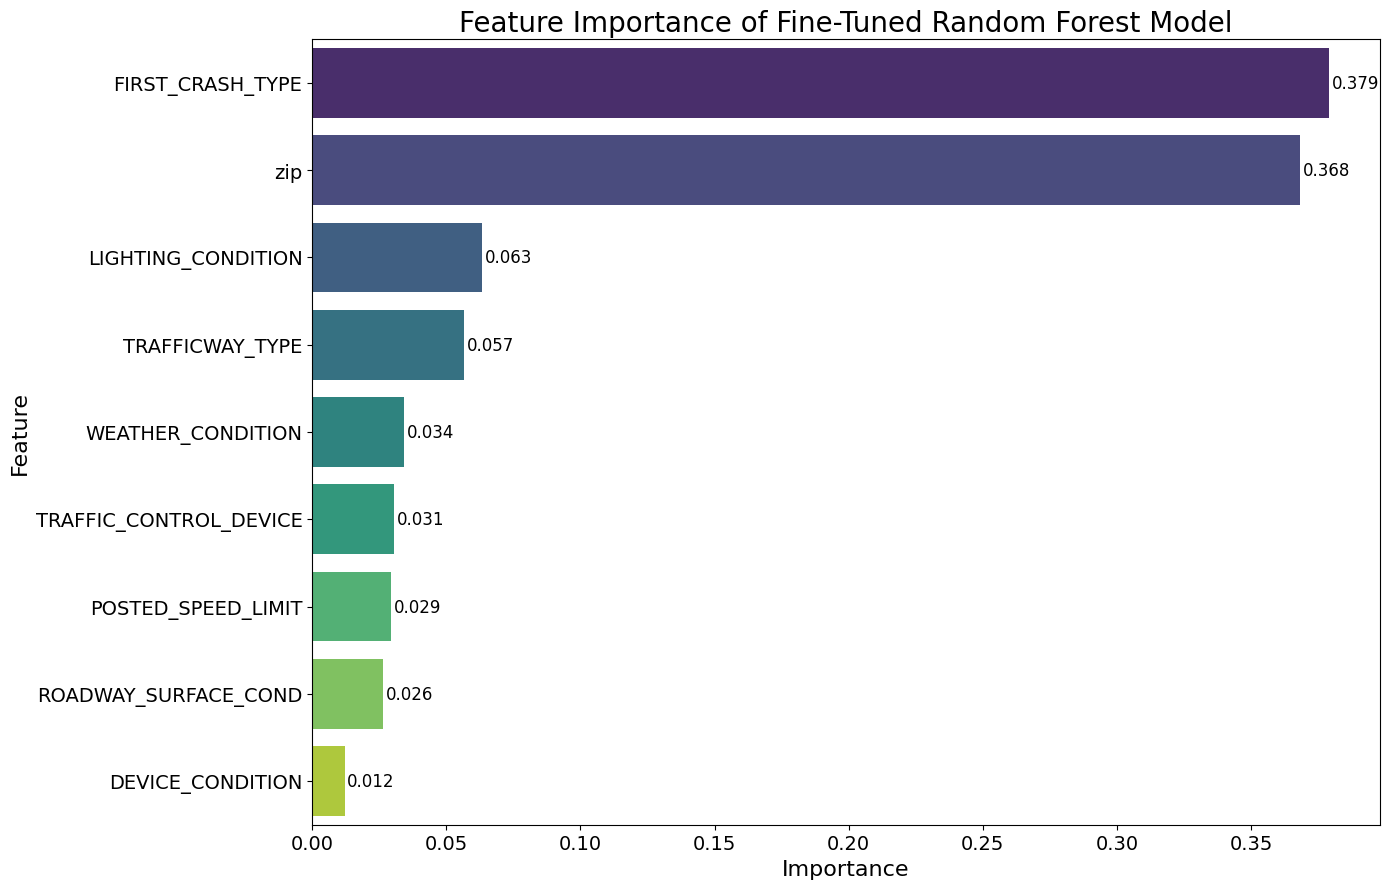

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Retreive feature importances in chart
importances = best_model.feature_importances_
features = X_train.columns

# Create dataframe with feature + importance
feat_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Display plot from greatest to least features and their importance score
plt.figure(figsize=(14, 9))
ax = sns.barplot(x='importance', y='feature', data=feat_df, palette='viridis')

for i, (val, name) in enumerate(zip(feat_df['importance'], feat_df['feature'])):
    ax.text(val + 0.001, i, f"{val:.3f}", va='center', fontsize=12)

plt.title('Feature Importance of Fine-Tuned Random Forest Model', fontsize=20)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

## Final Model Performance Summary Comparison (Heatmap + Avg Rank)

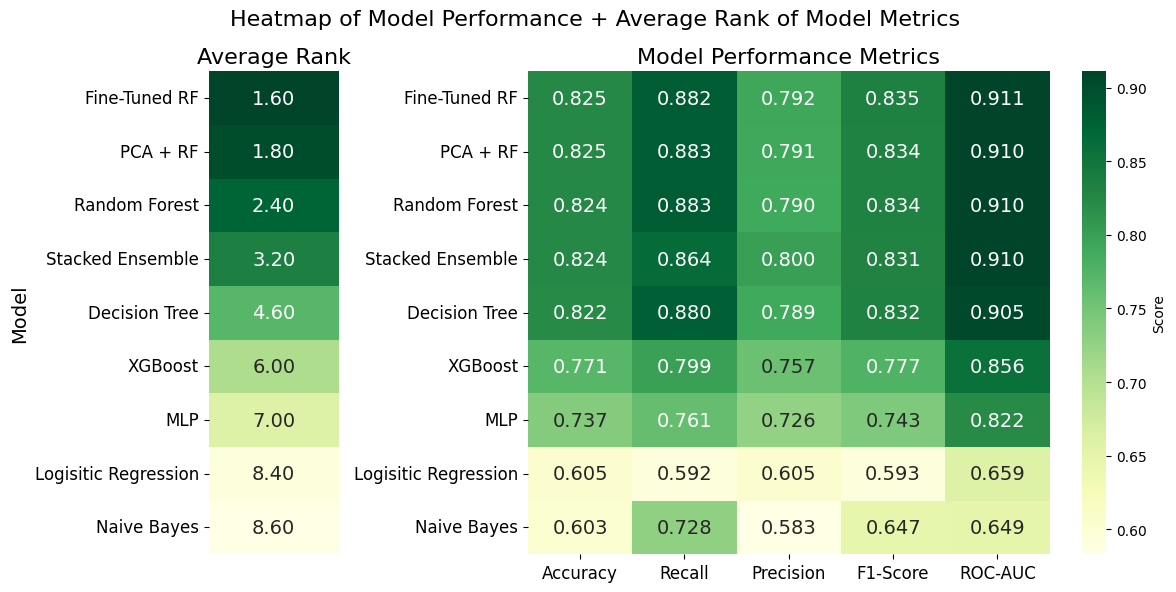

In [ ]:
model_results = pd.DataFrame({
    'Model':['Logisitic Regression', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Decision Tree', 'MLP', 'Stacked Ensemble', 'PCA + RF', 'Fine-Tuned RF'],
    'Accuracy': [0.605, 0.824, 0.603, 0.771, 0.822, 0.737, 0.824, 0.825, 0.825],
    'Recall': [0.592, 0.883, 0.728, 0.799, 0.880, 0.761, 0.864, 0.883, 0.882],
    'Precision': [0.605, 0.790, 0.583, 0.757, 0.789, 0.726, 0.800, 0.791, 0.792],
    'F1-Score': [0.593, 0.834, 0.647, 0.777, 0.832, 0.743, 0.831, 0.834, 0.835],
    'ROC-AUC': [0.659, 0.910, 0.649, 0.856, 0.905, 0.822, 0.910, 0.910, 0.911]
})

# Calculate average ranks
score_df = model_results.set_index('Model')
rank_df = score_df.rank(ascending=False, method = 'min', axis=0)
avg_rank = rank_df.mean(axis=1)

# Insert average rank as a new column for left-side display
display_df = score_df.copy()
display_df.insert(0, 'Avg Rank', avg_rank)

# Sort rows by avg rank, best model is top of heatmap
display_df = display_df.sort_values(by='Avg Rank')

# Split into heatmap values and rank column
rank_column = display_df[['Avg Rank']]
heatmap_values = display_df.drop(columns=['Avg Rank'])

# Set up the grid for plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 5]})

# Plot the avg rank as its own heatmap
sns.heatmap(rank_column, annot=True, cmap='YlGn_r', cbar=False, ax=ax1,
            fmt=".2f", annot_kws={"size": 14})
ax1.set_title("Average Rank", fontsize=16)
ax1.set_ylabel("Model", fontsize=14)
ax1.tick_params(axis='y', labelsize=12, labelrotation=0)
ax1.tick_params(axis='x', bottom=False, labelbottom=False)

# Plot all metric heatmap + average rank for each model
sns.heatmap(heatmap_values, annot=True, cmap='YlGn', ax=ax2, cbar_kws={'label': 'Score'},
            fmt=".3f", annot_kws={"size": 14})
ax2.set_title("Model Performance Metrics", fontsize=16)
ax2.set_ylabel("")
ax2.set_xlabel("", fontsize=14)
ax2.tick_params(axis='y', labelsize=12, labelrotation=0)
ax2.tick_params(axis='x', labelsize=12)

plt.suptitle('Heatmap of Model Performance + Average Rank of Model Metrics', fontsize=16)
plt.tight_layout()
plt.show()

## TOP FEATURE IMPORTANCES TO CLEAR POLICY INSIGHTS

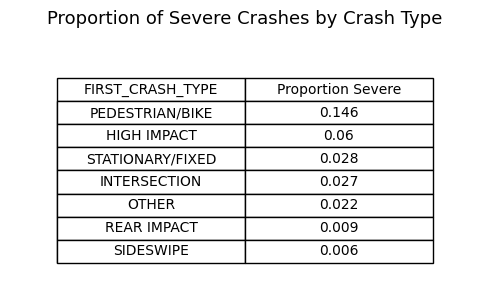

In [ ]:
from pandas.plotting import table

crash_type_labels = encoders['FIRST_CRASH_TYPE'].classes_
feature = 'FIRST_CRASH_TYPE'
encoded = df.groupby('FIRST_CRASH_TYPE')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])

styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by Crash Type', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()

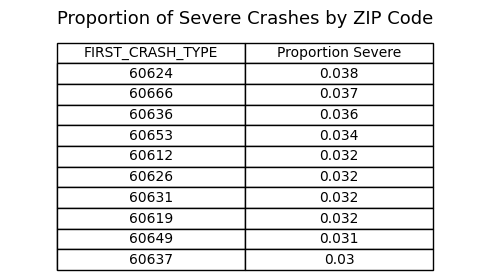

In [ ]:
crash_type_labels = encoders['zip'].classes_

encoded = df.groupby('zip')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])
decoded = decoded.head(10)

styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by ZIP Code', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()

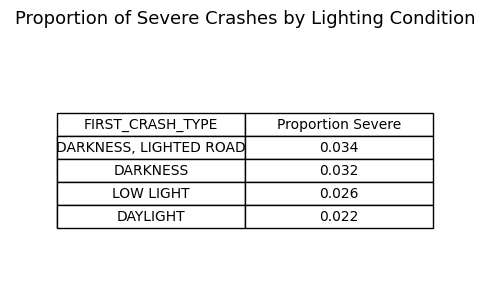

In [ ]:
crash_type_labels = encoders['LIGHTING_CONDITION'].classes_

encoded = df.groupby('LIGHTING_CONDITION')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])


styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by Lighting Condition', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()

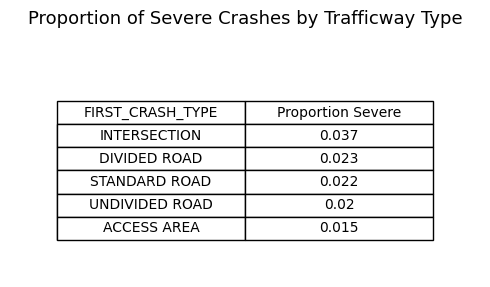

In [ ]:
crash_type_labels = encoders['TRAFFICWAY_TYPE'].classes_

encoded = df.groupby('TRAFFICWAY_TYPE')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])


styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by Trafficway Type', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()


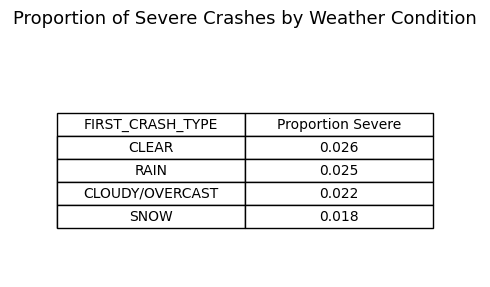

In [ ]:
crash_type_labels = encoders['WEATHER_CONDITION'].classes_

encoded = df.groupby('WEATHER_CONDITION')['severe'].mean().sort_values(ascending = False)
decoded = encoded.rename(index = lambda x: crash_type_labels[x])

styled_table = decoded.reset_index()
styled_table.columns = [feature, 'Proportion Severe']

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis('off')

tbl = plt.table(
    cellText=styled_table.round(3).values,
    colLabels=styled_table.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.4] * len(styled_table.columns),
    rowLabels=[""] * styled_table.shape[0]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title('Proportion of Severe Crashes by Weather Condition', fontsize=13, y=1.15)
plt.tight_layout()
plt.show()